In [1]:
import networkx
import numpy as np
import importlib
import quasibi
import glob
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm import tqdm
importlib.reload(quasibi);

In [15]:
qbo = pd.read_fwf("../data/qbo.txt", skiprows=9, header=None, usecols=[1, 8], index_col=0)
qbo.index = [datetime(year=1953 + month//12, month=month%12 + 1, day=1) for month in range(len(qbo))]
qbo = qbo[(qbo.index.year >= 1981) & (qbo.index.year < 2021)]
qbo = qbo[(qbo.index.month >= 10) | (qbo.index.month <= 3)]
qbo = qbo.groupby(qbo.index.year - (qbo.index.month <= 3)).mean()
qbo = qbo.to_numpy().flatten()

In [3]:
pearson_files = glob.glob("../output/dynamic/pearson*")

In [4]:
M = np.zeros((len(pearson_files), 3))

for i, pearson_file in tqdm(enumerate(pearson_files), total=41):
    pearson = quasibi.load_symmat(pearson_file)
    pearson = np.abs(pearson) >= np.quantile(np.abs(pearson), 0.995)

    net = networkx.from_numpy_matrix(pearson)

    # average path length
    M[i, 0] = networkx.average_clustering(net)

    # transitivity
    M[i, 1] = networkx.transitivity(net)

    # centrality
    M[i, 2] = np.fromiter(networkx.closeness_centrality(net).values(), dtype="float32").mean()

100%|███████████████████████████████████████████| 41/41 [00:20<00:00,  2.01it/s]


In [5]:
M = (M - np.mean(M, axis=0))/np.std(M, axis=0)

/var/folders/hd/zvzpfrkd3j7dmtgkz1ghzq200000gn/T/ipykernel_48264/3352501296.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([] if i < 2 else time)


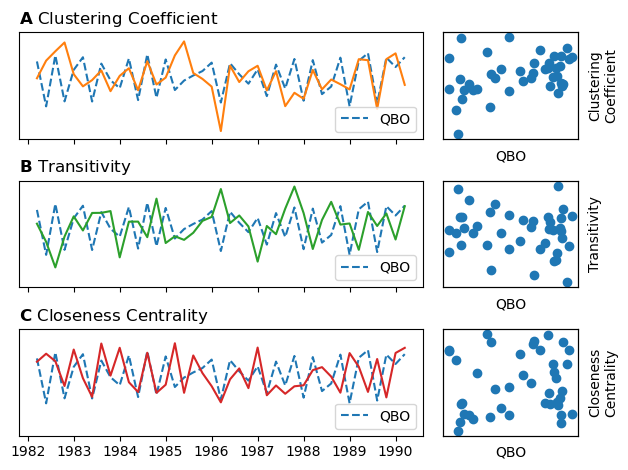

In [71]:
fig, axs = plt.subplots(3, 2, gridspec_kw={"width_ratios": [3, 1]})

time = np.arange(1981, 2022)

for i, (m, ax) in enumerate(zip(M.T, axs.T[0])):
    ax.plot(time, (qbo - np.mean(qbo))/np.std(qbo), ls="--", label="QBO")
    ax.plot(time, m, c="C"+str(i+1))
    ax.set_title(r"$\bf{" + ["A", "B", "C"][i] + "}$ " + ["Clustering Coefficient", "Transitivity", "Closeness Centrality"][i], loc="left")
    ax.set_yticks([])
    ax.set_ylim([-3.5, 2.5])
    ax.set_xticklabels([] if i < 2 else time)
    ax.legend(loc="lower right")
    #ax.imshow(np.expand_dims(qbo, 1).T, extent=[-0.5, 39.5, -2.5, 2.5], cmap="coolwarm", vmin=-310, vmax=310)


for i, (m, ax) in enumerate(zip(M.T, axs.T[1])):
    ax.scatter(qbo, m)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("QBO")
    ax.set_ylabel("")
    ax = ax.twinx()
    ax.set_yticks([])
    ax.set_ylabel(["Clustering\nCoefficient", "Transitivity", "Closeness\nCentrality"][i])
    pass

plt.tight_layout()
plt.savefig("../plots/dynamic.pdf", bbox_inches="tight")